In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [19]:

with open("Data/processed_df.pkl", "rb") as f:
    df = pickle.load(f)

print(df.shape)

(404287, 6)


In [20]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [21]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


* This block performs TF-IDF vectorization on the question1 and question2 columns to convert the text into numerical feature vectors using batch processing to avoid memory errors

In [22]:
questions = list(ques_df['question1'].astype(str)) + list(ques_df['question2'].astype(str))

tfidf = TfidfVectorizer(max_features=3000)
tfidf.fit(questions[:50000])  

batch_size = 50000
sparse_batches = []

for i in range(0, len(questions), batch_size):
    batch = questions[i:i+batch_size]
    X_batch = tfidf.transform(batch)  
    sparse_batches.append(X_batch)

full_sparse_matrix = vstack(sparse_batches)

n = len(ques_df)
q1_sparse = full_sparse_matrix[:n]
q2_sparse = full_sparse_matrix[n:]

print(f"q1 shape: {q1_sparse.shape}, q2 shape: {q2_sparse.shape}")


q1 shape: (404287, 3000), q2 shape: (404287, 3000)


In [23]:
X = hstack([q1_sparse, q2_sparse])  
y = df['is_duplicate'].astype(int) 

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,ConfusionMatrixDisplay

* This code trains and evaluates the following classification models:

    Logistic Regression

    Naive Bayes

    Random Forest

    AdaBoost

    XGBoost

    evaluates their performance on the test set using metrics like accuracy, precision, recall, and F1, and visualizes the results using confusion matrices.

 Model: Logistic Regression
 Accuracy:  0.7395
 Precision: 0.6941
 Recall:    0.5250
 F1 Score:  0.5978


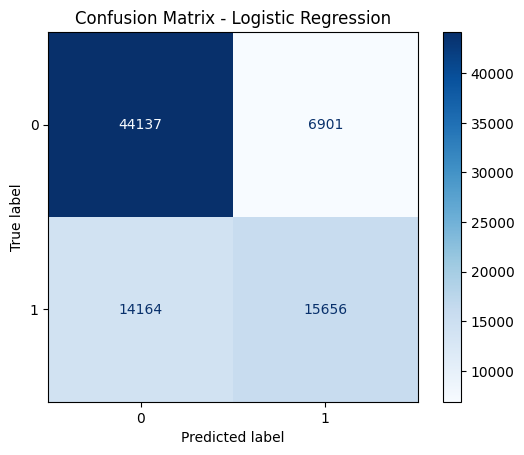

 Model: Naive Bayes
 Accuracy:  0.7268
 Precision: 0.6790
 Recall:    0.4915
 F1 Score:  0.5702


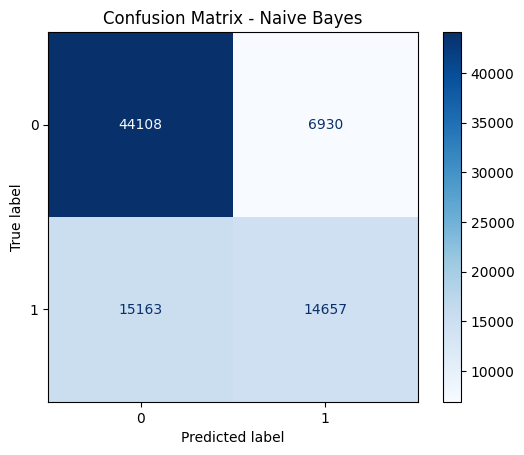

 Model: Random Forest
 Accuracy:  0.8062
 Precision: 0.8334
 Recall:    0.5931
 F1 Score:  0.6930


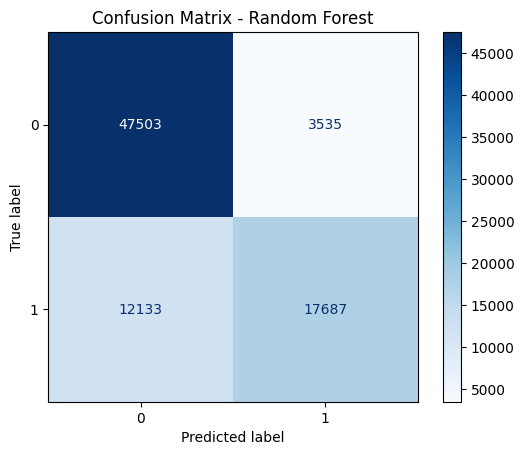

 Model: AdaBoost
 Accuracy:  0.6418
 Precision: 0.8157
 Recall:    0.0373
 F1 Score:  0.0713


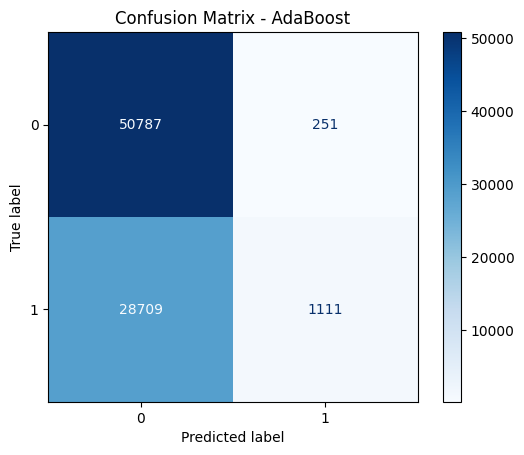

 Model: XGBoost
 Accuracy:  0.7489
 Precision: 0.7603
 Recall:    0.4659
 F1 Score:  0.5778


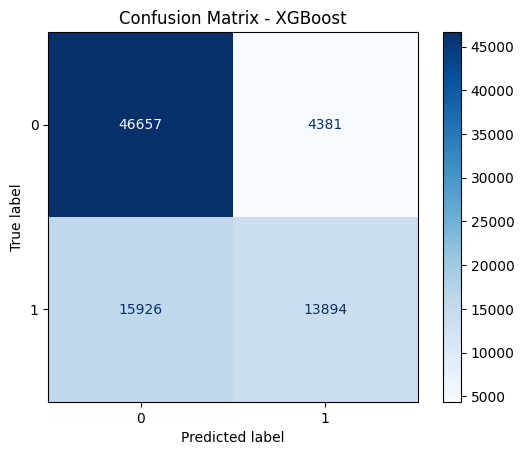

In [26]:
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear'),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier()
}

model_names = []
f1_scores = []
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    model_names.append(name)
    f1_scores.append(f1)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4)
    })

    print(f" Model: {name}")
    print(f" Accuracy:  {acc:.4f}")
    print(f" Precision: {prec:.4f}")
    print(f" Recall:    {rec:.4f}")
    print(f" F1 Score:  {f1:.4f}")
    print("="*40)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.grid(False)
    plt.show()

# Model Performance Summary Table : 
    The table below presents the evaluation metrics for each machine learning model used in the duplicate question detection task:

    * Metric Description : 
        1. Accuracy	Overall correctness of the model’s predictions (can be misleading in imbalance).
        2. Precision	Of the predicted duplicates, how many were actually correct.
        3. Recall	Of the actual duplicates, how many were correctly identified.
        4. F1 Score	Harmonic mean of Precision and Recall — best when classes are imbalanced.

In [31]:
results_df = pd.DataFrame(results)
display(results_df)

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.7395,0.6941,0.5250,0.5978
1,Naive Bayes,0.7268,0.6790,0.4915,0.5702
2,Random Forest,0.8062,0.8334,0.5931,0.6930
3,AdaBoost,0.6418,0.8157,0.0373,0.0713
4,XGBoost,0.7489,0.7603,0.4659,0.5778


# Model Comparison Based on F1 Score
The below bar chart illustrates the F1 Scores achieved by different machine learning models trained for duplicate question detection

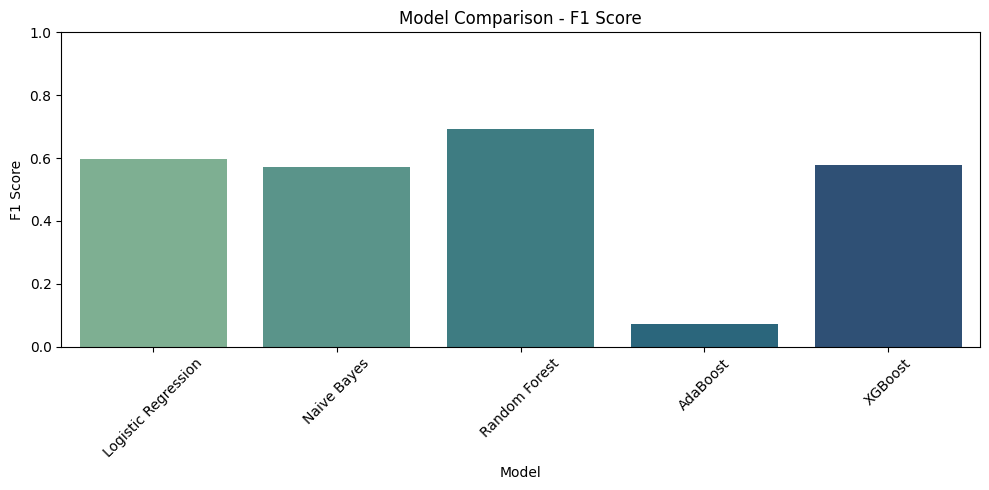

In [34]:
results_df = pd.DataFrame({'Model': model_names, 'F1 Score': f1_scores})

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='F1 Score', hue='Model', data=results_df, palette="crest", legend=False)
plt.title("Model Comparison - F1 Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
